In [23]:
#Añadir la raiz del proyecto temporal
import sys
sys.path.insert(0, "/home/ubuntu/projects/historical-analysis-management-tickets")

In [31]:
#dependencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import os
from src.configuraciones import configuracion_visual
from src.configuraciones import configuracion_format_df

In [274]:
#cargar dfs
folder_p = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed_SC"
df_all = pd.read_csv(f"{folder_p}/df_all.csv")

In [275]:
#configuracion
#visual
configuracion_visual()

#arreglo de datos
df_all = configuracion_format_df(df_all)

#vista de df
print("Dataframe cargado con éxito. Dimensiones:", df_all.shape)
print(f"Tickets disponibles: {df_all.shape[0]}")
print("Columnas disponibles:", df_all.columns.tolist())

Configurado visualmente
Configuracion fechas lista
Dataframe cargado con éxito. Dimensiones: (111619, 34)
Tickets disponibles: 111619
Columnas disponibles: ['Unnamed: 0', 'id', 'titulo', 'estado', 'ultima_modificacion', 'fecha_de_apertura', 'prioridad', 'solicitante__solicitante', 'asignado_a__grupo_de_tecnicos', 'asignado_a__tecnico', 'categoria', 'origen_de_la_solicitud', 'ubicacion', 'seguimientos__origen_de_la_solicitud', 'fecha_de_cierre', 'fecha_de_solucion', 'cumple_SLA', 'fecha_de_apertura_dia', 'fecha_de_apertura_mes', 'fecha_de_apertura_año', 'fecha_de_apertura_hora', 'fecha_de_apertura_periodo_mes', 'creado_en_horario_laboral', 'area', 'servicio', 'tiempo_vida_horas', 'prioridad_num', 'weekday', 'hour', 'es_sin_categoria', 'Estado Categoria', 'Estado Asignacion', 'Estado Asignacion grupal', 'Estado Asignacion Total']


In [295]:
#areas infra TI
areas_infra = ["DBA", "Ingenieros TI", "Técnico TI"]

#ingenieros del area
ingenieros = ["Orieta Catalan Ossandon (9)",
              "Cesar Milko Lazo Valencia (8)",
              "Gonzalo Alejandro Tobar Ramirez (17)",
              "Cesar Milko Lazo Valencia (8) <br>Orieta Catalan Ossandon (9)",
              "Cesar Milko Lazo Valencia (8) <br>Gonzalo Alejandro Tobar Ramirez (17)",
              "Jean Franco Andre Miranda Astudillo (14)",
              ""]

#filtro de llamadas o cosas de prueba (ruido)
servicio_prueba = ["Llamado de Prueba", "Llamado Cortado / Liberado", "Consulta Ticket"]

#flag de si es infra o no
df_all['es_infraestructura'] = ((df_all['area'].isin(areas_infra)) | 
                                (df_all["asignado_a__tecnico"].isin(ingenieros) & (df_all['area'] == "Sin Categoria")))

#df infra
df_infra = df_all[df_all['es_infraestructura']].copy()
n_ruido = df_infra[df_infra["servicio"].isin(servicio_prueba)].shape[0]

print(f"Total Tickets: {len(df_all)}")
print(f"Tickets Infraestructura (True): {len(df_infra)}")
print(f"Peso Operativo: {df_all['es_infraestructura'].mean()*100:.1f}% del total")
print(f"Ticket de infra TI con ruido: {n_ruido}")

df_infra = df_infra[~df_infra["servicio"].isin(servicio_prueba)]
print(f"Registros restantes: {len(df_infra)}")
print()

#tickets totales de infra TI por año
prueba = df_infra[df_infra["fecha_de_apertura_año"].between(2022,2025)]
print(prueba.groupby("fecha_de_apertura_año")["id"].count())


Total Tickets: 111619
Tickets Infraestructura (True): 37056
Peso Operativo: 33.2% del total
Ticket de infra TI con ruido: 0
Registros restantes: 37056

fecha_de_apertura_año
2022     1475
2023    12342
2024    11580
2025    11046
Name: id, dtype: int64


/tmp/ipykernel_267922/1752776598.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_perf, x='es_infraestructura', y='tiempo_vida_horas',
/tmp/ipykernel_267922/1752776598.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Otras Áreas (False)', 'Infraestructura TI (True)'])


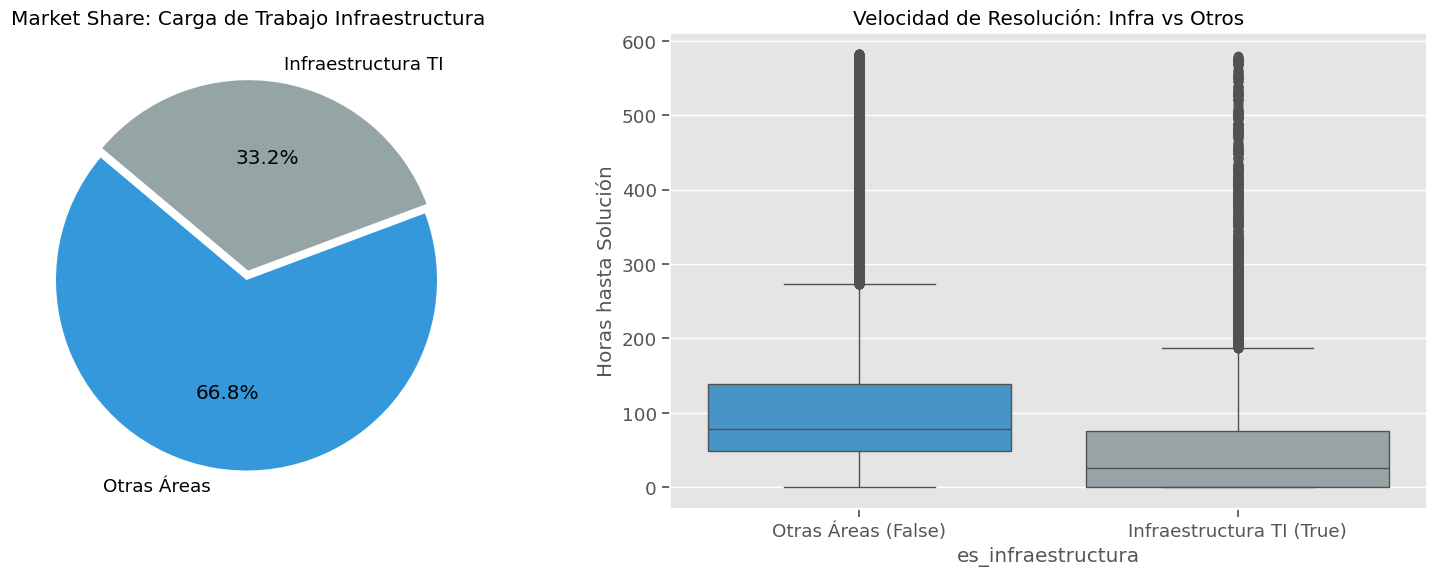

Tickets infra TI con mayor tiempo de Resolucion
                area                  servicio  tiempo_vida_horas
26787  Ingenieros TI  SCADA Infraestructura TI            9144.65
25774            DBA     Revisión Servicio SAP            8789.50
5730      Técnico TI                   General            8375.77
35519  Ingenieros TI  SCADA Infraestructura TI            6909.07
16415            DBA                   General            6198.27


In [296]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#grafico Distribucion de trabajo (pie chart)
conteo_macro = df_all['es_infraestructura'].value_counts()
labels_map = {True: 'Infraestructura TI', False: 'Otras Áreas'}
labels = [labels_map[x] for x in conteo_macro.index]

axes[0].pie(conteo_macro, labels=labels, autopct='%1.1f%%', 
            startangle=140, colors=['#3498db', '#95a5a6'], explode=(0.05, 0))
axes[0].set_title('Market Share: Carga de Trabajo Infraestructura')

#grafico velocidad de resolucion (boxplot)
#outliers <95
q95 = df_all['tiempo_vida_horas'].quantile(0.95)
df_perf = df_all[df_all['tiempo_vida_horas'] < q95]

sns.boxplot(data=df_perf, x='es_infraestructura', y='tiempo_vida_horas', 
            palette=['#3498db', '#95a5a6'], ax=axes[1])

axes[1].set_xticklabels(['Otras Áreas (False)', 'Infraestructura TI (True)'])
axes[1].set_title('Velocidad de Resolución: Infra vs Otros')
axes[1].set_ylabel('Horas hasta Solución')

plt.tight_layout()
plt.show()

df_pp = df_perf.sort_values("tiempo_vida_horas", ascending=False)
print("Tickets infra TI con mayor tiempo de Resolucion")
print(df_infra[["area","servicio", "tiempo_vida_horas"]].sort_values("tiempo_vida_horas",ascending=False).head(5))

/tmp/ipykernel_267922/514055610.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_global.values, y=top_global.index, palette='mako', ax=axes[0])
/tmp/ipykernel_267922/514055610.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_infra.values, y=top_infra.index, palette='mako', ax=axes[1])


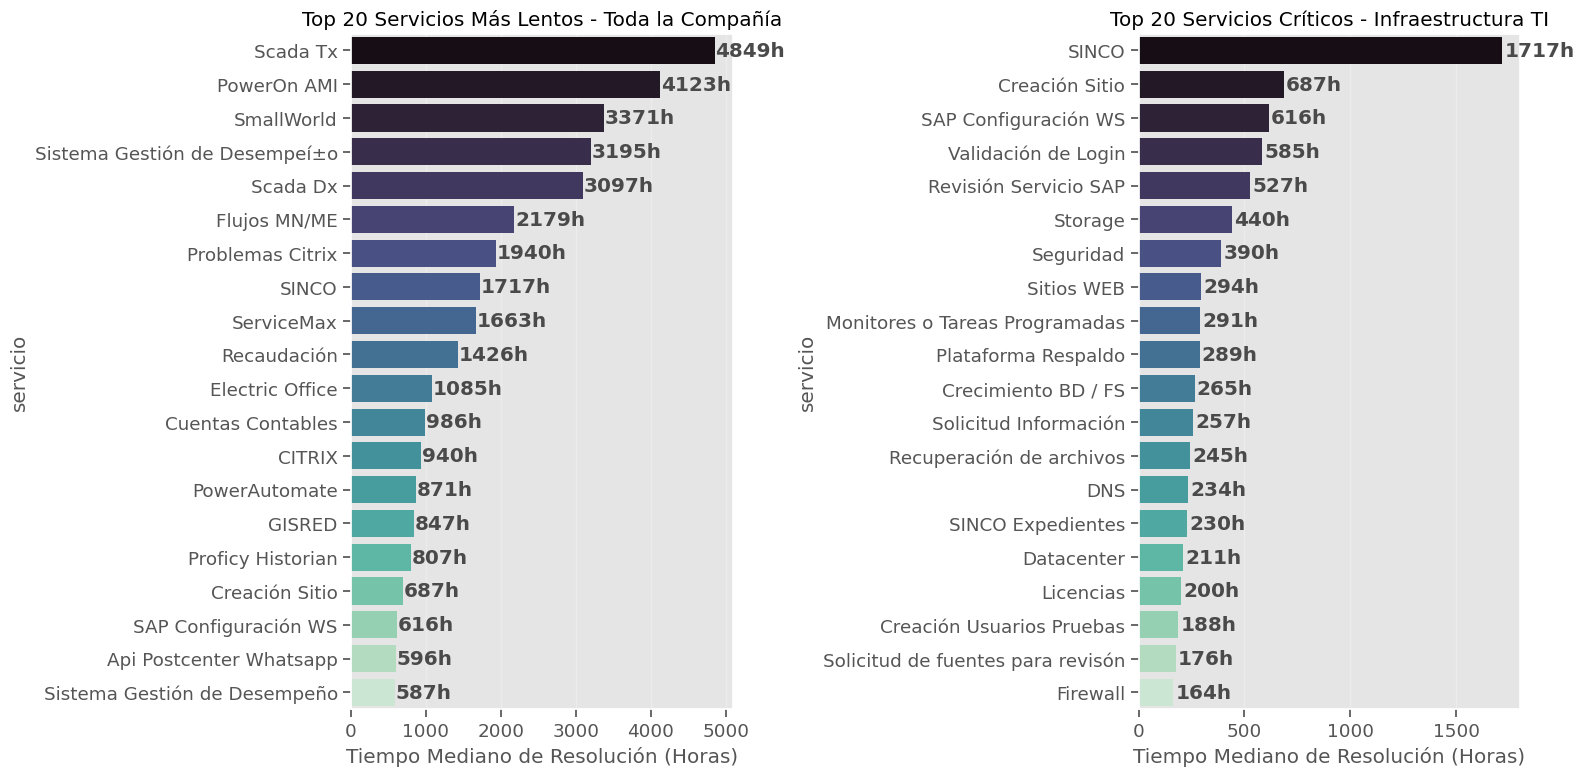

Interpretación:
El servicio más lento de Infraestructura ('SINCO') toma 71.5 días en resolverse (mediana).


In [297]:
#tiempos de resolucion mayores global vs infra TI
num=20
top_global = df_all.groupby('servicio')['tiempo_vida_horas'].median().sort_values(ascending=False).head(num)
top_infra = df_infra.groupby('servicio')['tiempo_vida_horas'].median().sort_values(ascending=False).head(num)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico izq global
sns.barplot(x=top_global.values, y=top_global.index, palette='mako', ax=axes[0])
axes[0].set_title(f'Top {num} Servicios Más Lentos - Toda la Compañía')
axes[0].set_xlabel('Tiempo Mediano de Resolución (Horas)')
axes[0].grid(True, axis='x', alpha=0.3)

for i, v in enumerate(top_global.values):
    axes[0].text(v + 10, i, f"{v:.0f}h", va='center', fontweight='bold', color='#4a4a4a')

# Gráfico der infra TI
sns.barplot(x=top_infra.values, y=top_infra.index, palette='mako', ax=axes[1])
axes[1].set_title(f'Top {num} Servicios Críticos - Infraestructura TI')
axes[1].set_xlabel('Tiempo Mediano de Resolución (Horas)')
axes[1].grid(True, axis='x', alpha=0.3)

for i, v in enumerate(top_infra.values):
    axes[1].text(v + 10, i, f"{v:.0f}h", va='center', fontweight='bold', color='#4a4a4a')

plt.tight_layout()
plt.show()

print("Interpretación:")
print(f"El servicio más lento de Infraestructura ('{top_infra.index[0]}') toma {top_infra.values[0]/24:.1f} días en resolverse (mediana).")


--- KPIs de Sub-Áreas (Infraestructura) ---
               Volumen  Tiempo_Mediana  Tecnicos_Activos  Tickets_por_Tecnico
area                                                                         
DBA              27886            4.30                84               332.00
Ingenieros TI     5080           63.00               115                44.20
Técnico TI        2818           87.70                64                44.00
Sin Categoria     1272           71.60                 5               254.40


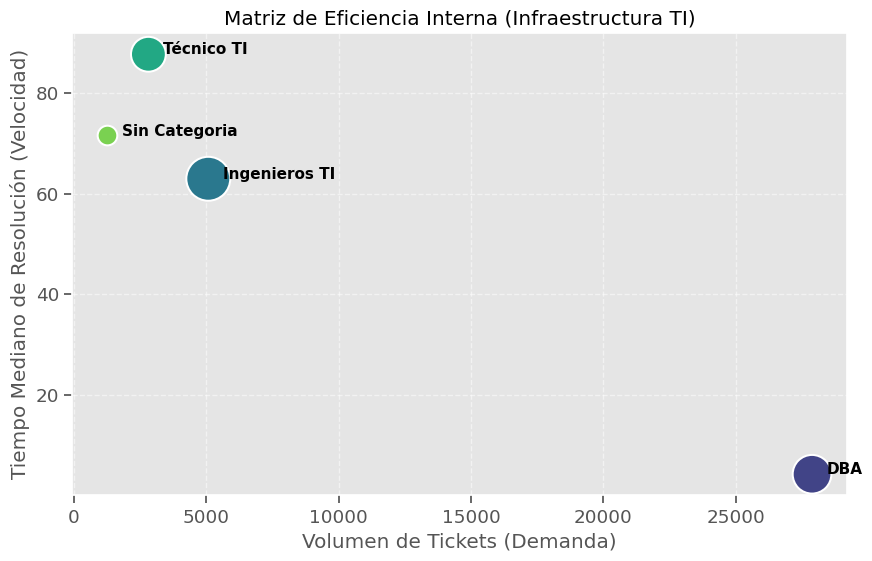

In [304]:
#KPIs del area
kpis_infra = df_infra.groupby('area').agg(
    Volumen=('id', 'count'),
    Tiempo_Mediana=('tiempo_vida_horas', 'median'),
    Tecnicos_Activos=('asignado_a__tecnico', 'nunique')
).sort_values('Volumen', ascending=False)

# Métricas derivadas
kpis_infra['Tickets_por_Tecnico'] = kpis_infra['Volumen'] / kpis_infra['Tecnicos_Activos']

print("\n--- KPIs de Sub-Áreas (Infraestructura) ---")
print(kpis_infra.round(1))

# --- Gráfico 3.1: Matriz de Eficiencia (Bubble Chart) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=kpis_infra, x='Volumen', y='Tiempo_Mediana', 
                size='Tecnicos_Activos', sizes=(200, 1000), 
                hue=kpis_infra.index, palette='viridis', legend=False)

# Etiquetas de texto
for i in range(kpis_infra.shape[0]):
    x = kpis_infra['Volumen'].iat[i]
    y = kpis_infra['Tiempo_Mediana'].iat[i]
    label = kpis_infra.index[i]
    plt.text(x + (kpis_infra['Volumen'].max()*0.02), y, label, weight='bold', fontsize=11)

plt.title('Matriz de Eficiencia Interna (Infraestructura TI)')
plt.xlabel('Volumen de Tickets (Demanda)')
plt.ylabel('Tiempo Mediano de Resolución (Velocidad)') # Cuanto más bajo, mejor
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


KPIs de Sub-Áreas (Infraestructura)
               Volumen  Tiempo_Mediana  Tecnicos_Activos  Tickets_por_Tecnico
area                                                                         
DBA               8582            0.20                34               252.40
Ingenieros TI     1788           43.30                64                27.90
Técnico TI         612           92.90                22                27.80
Sin Categoria       64           68.70                 2                32.00


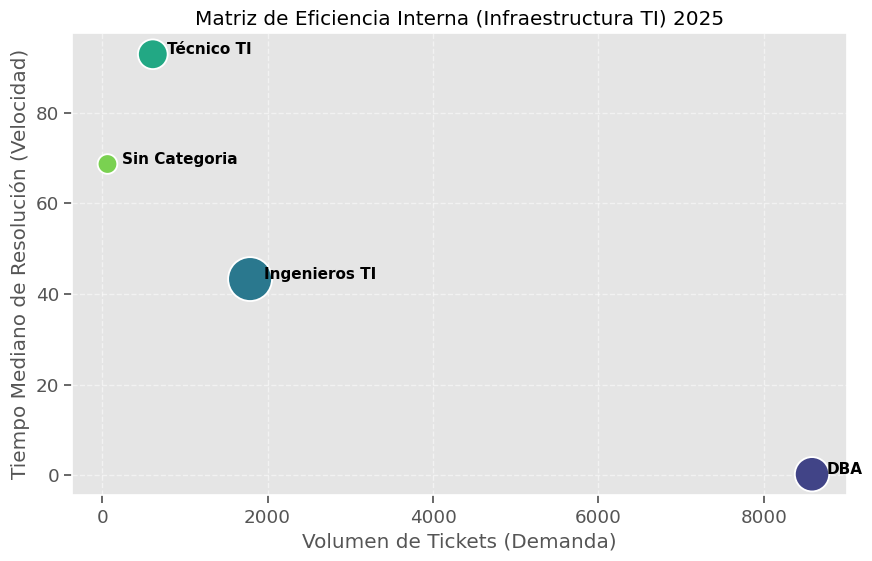

In [306]:
#KPIs del area 2025
kpis_infra = df_infra[df_infra["fecha_de_apertura_año"] == 2025].groupby('area').agg(
    Volumen=('id', 'count'),
    Tiempo_Mediana=('tiempo_vida_horas', 'median'),
    Tecnicos_Activos=('asignado_a__tecnico', 'nunique')
).sort_values('Volumen', ascending=False)

# Métricas derivadas
kpis_infra['Tickets_por_Tecnico'] = kpis_infra['Volumen'] / kpis_infra['Tecnicos_Activos']

print("\nKPIs de Sub-Áreas (Infraestructura)")
print(kpis_infra.round(1))

# --- Gráfico 3.1: Matriz de Eficiencia (Bubble Chart) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=kpis_infra, x='Volumen', y='Tiempo_Mediana', 
                size='Tecnicos_Activos', sizes=(200, 1000), 
                hue=kpis_infra.index, palette='viridis', legend=False)

# Etiquetas de texto
for i in range(kpis_infra.shape[0]):
    x = kpis_infra['Volumen'].iat[i]
    y = kpis_infra['Tiempo_Mediana'].iat[i]
    label = kpis_infra.index[i]
    plt.text(x + (kpis_infra['Volumen'].max()*0.02), y, label, weight='bold', fontsize=11)

plt.title('Matriz de Eficiencia Interna (Infraestructura TI) 2025')
plt.xlabel('Volumen de Tickets (Demanda)')
plt.ylabel('Tiempo Mediano de Resolución (Velocidad)') # Cuanto más bajo, mejor
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

/tmp/ipykernel_267922/569266074.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=top_tecnicos.values, y=top_tecnicos.index, palette='mako')


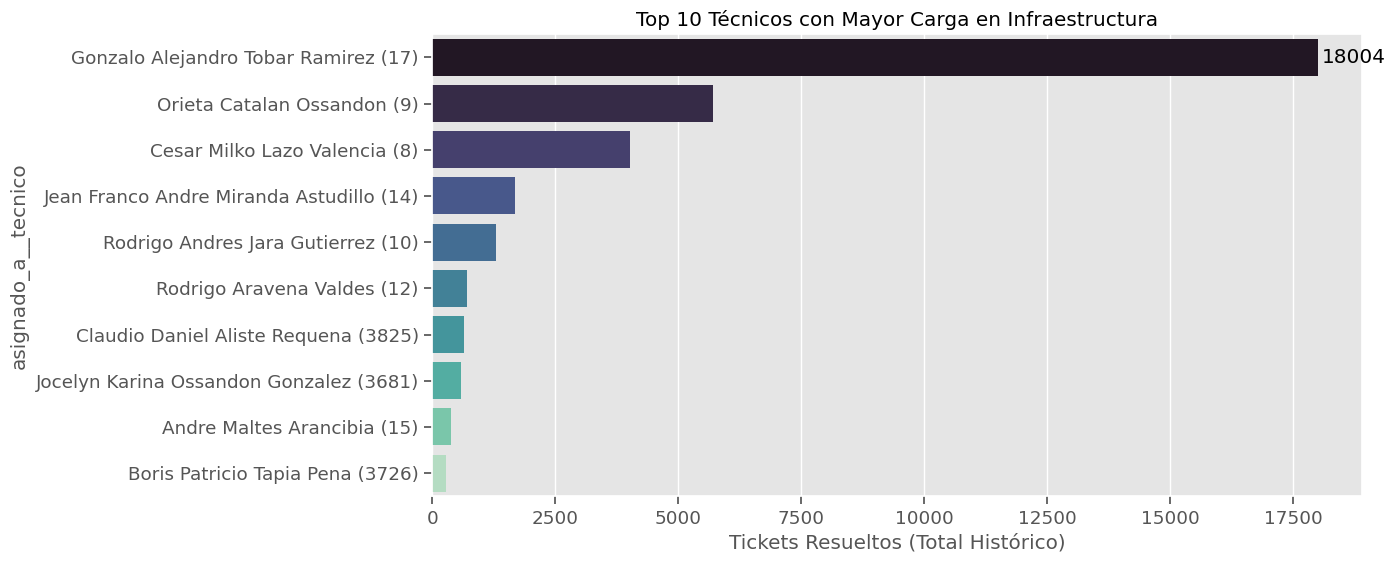

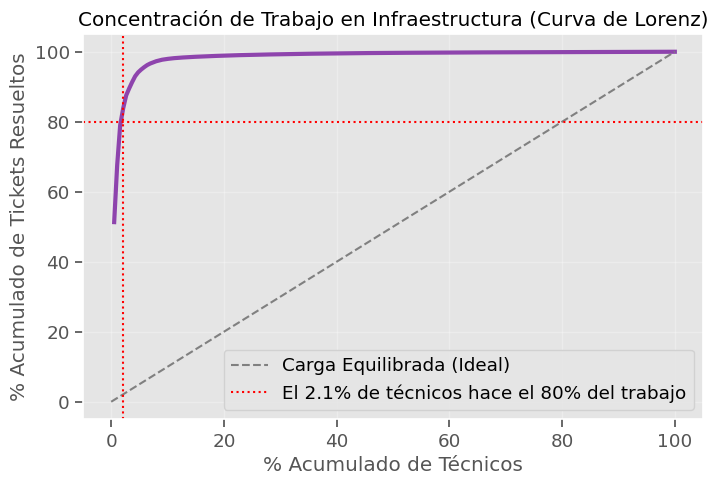

In [299]:
# Top 10 Técnicos de Infraestructura
top_tecnicos = df_infra['asignado_a__tecnico'].value_counts().head(10)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=top_tecnicos.values, y=top_tecnicos.index, palette='mako')
plt.title('Top 10 Técnicos con Mayor Carga en Infraestructura')
plt.xlabel('Tickets Resueltos (Total Histórico)')
plt.bar_label(barplot.containers[0], padding=3)
plt.show()

# Curva de Lorenz (Concentración de Trabajo)
cargas = df_infra['asignado_a__tecnico'].value_counts().values
cargas_ordenadas = np.sort(cargas)[::-1] # De mayor a menor
acumulado_tickets = np.cumsum(cargas_ordenadas) / cargas.sum() * 100
percentil_tecnicos = np.arange(1, len(cargas) + 1) / len(cargas) * 100

plt.figure(figsize=(8, 5))
plt.plot(percentil_tecnicos, acumulado_tickets, color='#8e44ad', linewidth=3)
plt.plot([0, 100], [0, 100], linestyle='--', color='gray', label='Carga Equilibrada (Ideal)')

# Punto de corte 80% (Pareto)
idx_pareto = np.argmax(acumulado_tickets >= 80)
pareto_x = percentil_tecnicos[idx_pareto]

plt.axvline(pareto_x, color='red', linestyle=':', label=f'El {pareto_x:.1f}% de técnicos hace el 80% del trabajo')
plt.axhline(80, color='red', linestyle=':')

plt.title('Concentración de Trabajo en Infraestructura (Curva de Lorenz)')
plt.xlabel('% Acumulado de Técnicos')
plt.ylabel('% Acumulado de Tickets Resueltos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [283]:
#analisis trabajo manual DBA Scripts
tk_gt = df_infra[df_infra["asignado_a__tecnico"] == "Gonzalo Alejandro Tobar Ramirez (17)"].sort_values("tiempo_vida_horas", ascending=False)
gt2025 = tk_gt[tk_gt["fecha_de_apertura_año"] == 2025]
gt2025[["area","estado","fecha_de_apertura_año","tiempo_vida_horas"]].head(10)

,area,estado,fecha_de_apertura_año,tiempo_vida_horas
90509,ABM,Cerrado,2025,1316.95
90925,ABM,Cerrado,2025,1202.83
88917,ABM,Cerrado,2025,983.72
90290,DBA,Cerrado,2025,669.97
87692,ABM,Cerrado,2025,478.58
90041,ABM,Cerrado,2025,342.43
94530,ABM,Cerrado,2025,312.42
105534,ABM,Cerrado,2025,312.38
90142,ABM,Cerrado,2025,213.13
88778,ABM,Cerrado,2025,191.98


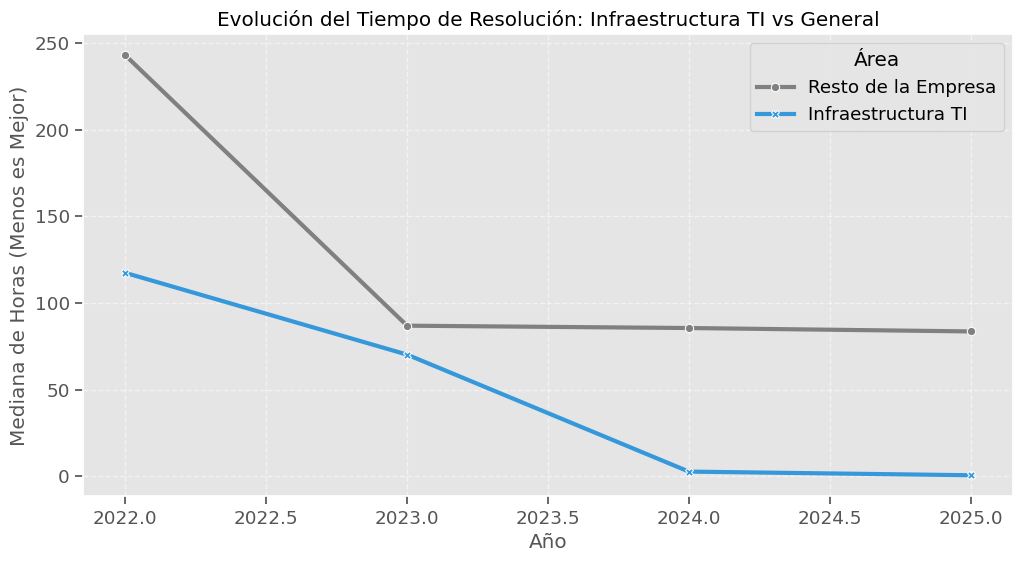

In [300]:
#analisis historico de tickets en infra TI
df_evolucion = df_all[df_all["fecha_de_apertura_año"].between(2022, 2025)].copy()

trend_general = df_evolucion.groupby(['fecha_de_apertura_año', 'es_infraestructura'])['tiempo_vida_horas'].median().unstack()
trend_general.columns = ['Resto de la Empresa', 'Infraestructura TI']

plt.figure(figsize=(12, 6))
# Lineplot
sns.lineplot(data=trend_general, markers=True, dashes=False, linewidth=3, palette=['gray', '#3498db'])

plt.title('Evolución del Tiempo de Resolución: Infraestructura TI vs General')
plt.ylabel('Mediana de Horas (Menos es Mejor)')
plt.xlabel('Año')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Área')
plt.show()

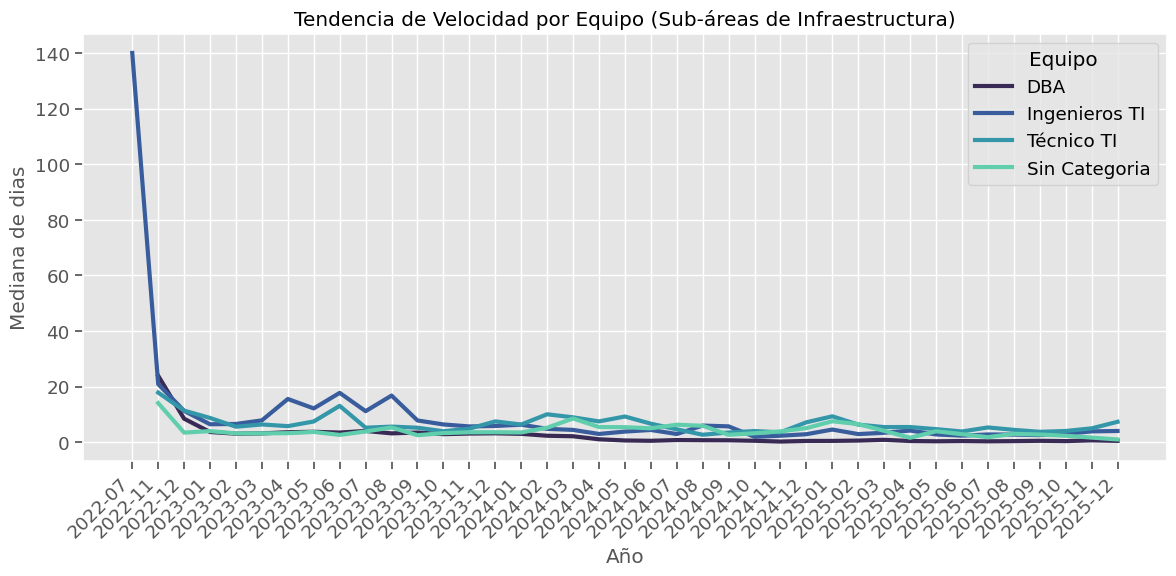

In [301]:
#Analisis evolutivo de subareas
df_infra_evo = df_evolucion[df_evolucion['es_infraestructura']].copy()

# Agrupamos por Año y Área Específica
trend_areas = df_infra_evo.groupby(["fecha_de_apertura_periodo_mes", 'area'])['tiempo_vida_horas'].mean().unstack()

trend_long = trend_areas.reset_index().melt(
    id_vars='fecha_de_apertura_periodo_mes',
    var_name='area',
    value_name='tiempo_vida_horas'
)

# convertir fecha y valores
trend_long['fecha_de_apertura_periodo_mes'] = trend_long['fecha_de_apertura_periodo_mes'].astype(str)
trend_long = trend_long.sort_values('fecha_de_apertura_periodo_mes')

plt.figure(figsize=(12,6))
sns.lineplot(data=trend_long,
             x='fecha_de_apertura_periodo_mes',
             y=trend_long['tiempo_vida_horas']/24,
             hue='area',
             markers=True, dashes=False, linewidth=3, palette='mako')
plt.xticks(rotation=45, ha='right')
plt.legend( loc='upper right', title='Equipo')
plt.title('Tendencia de Velocidad por Equipo (Sub-áreas de Infraestructura)')
plt.ylabel('Mediana de dias')
plt.xlabel('Año')
plt.tight_layout()
plt.show()

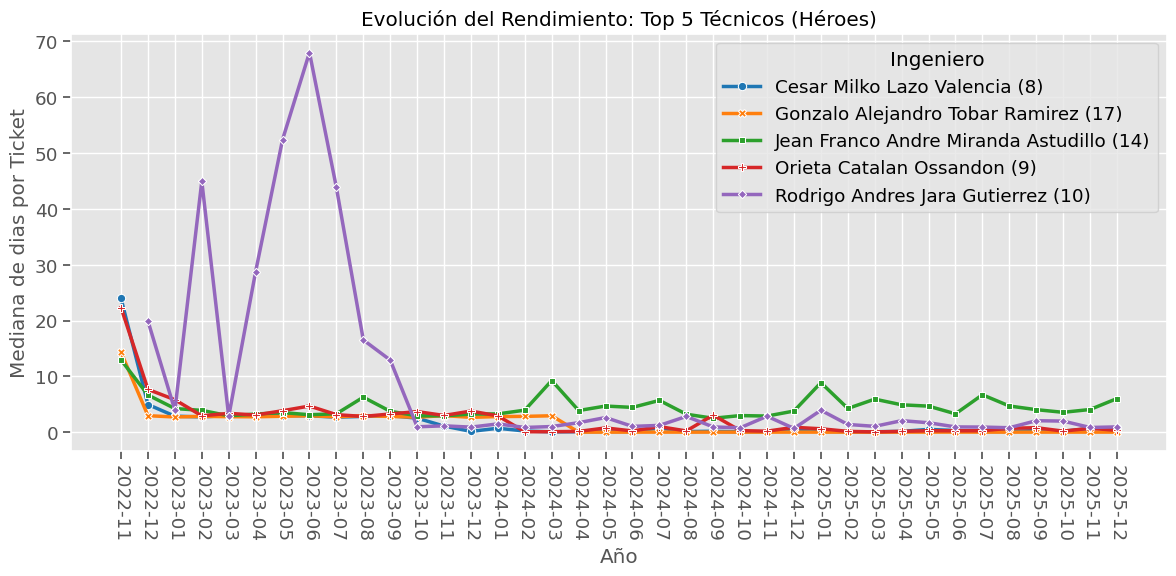

In [302]:
# top 5 ingenieros
top_5_tecnicos = df_infra_evo['asignado_a__tecnico'].value_counts().head(5).index.tolist()

# filtro
df_heroes = df_infra_evo[df_infra_evo['asignado_a__tecnico'].isin(top_5_tecnicos)]
df_heroes['fecha_de_apertura_periodo_mes'] = df_heroes['fecha_de_apertura_periodo_mes'].astype(str)
df_heroes['tiempo_vida_horas'] = df_heroes['tiempo_vida_horas']/24

# evolucion de tecnicos
trend_heroes = df_heroes.groupby(['fecha_de_apertura_periodo_mes', 'asignado_a__tecnico'])['tiempo_vida_horas'].median().unstack()

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_heroes, markers=True, dashes=False, linewidth=2.5, palette='tab10')

plt.title('Evolución del Rendimiento: Top 5 Técnicos (Héroes)')
plt.ylabel('Mediana de dias por Ticket')
plt.xlabel('Año')
plt.xticks(rotation=-90)
plt.legend(loc='upper right', title='Ingeniero')
plt.tight_layout()
plt.show()

/tmp/ipykernel_267922/1867386631.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=kpis_servicios, x='Volumen', y='Tiempo_Mediana',


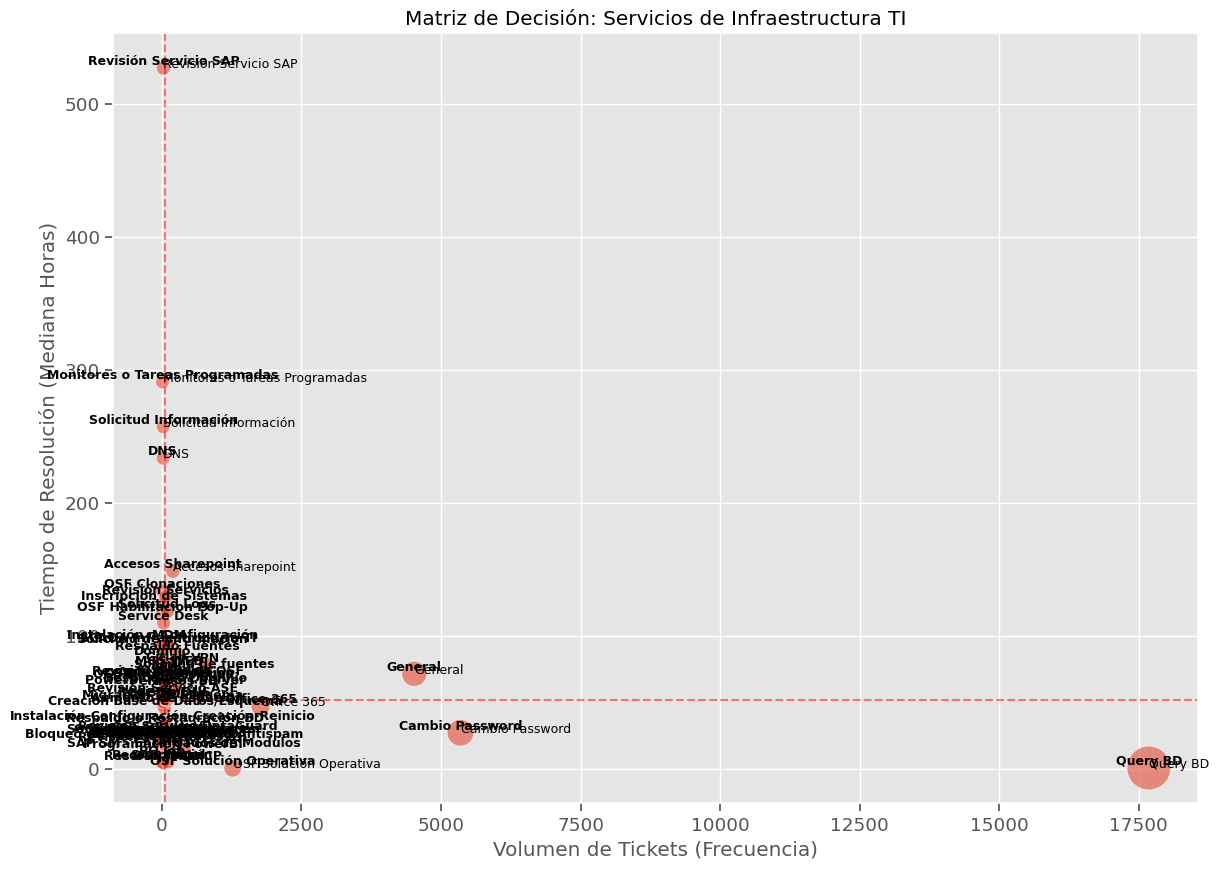

In [ ]:
#POSIBLES RAMAS DE INVESTIGACION

#posibilidades de automatizacion
df_infra = df_all[df_all['es_infraestructura']].copy()

#matriz de servicios
kpis_servicios = df_infra.groupby('servicio').agg(
    Volumen=('id', 'count'),
    Tiempo_Mediana=('tiempo_vida_horas', 'median')
).reset_index()

#filtro de servicios con muy pocos datos (ruido)
umbral_corte = 10 
kpis_servicios = kpis_servicios[kpis_servicios['Volumen'] > umbral_corte]

#puntos medios de division
mediana_vol = kpis_servicios['Volumen'].median()
mediana_tiempo = kpis_servicios['Tiempo_Mediana'].median()

plt.figure(figsize=(14, 10))
sns.scatterplot(data=kpis_servicios, x='Volumen', y='Tiempo_Mediana', 
                size='Volumen', sizes=(100, 1000), alpha=0.6, palette='coolwarm', legend=False)

# Líneas de Cuadrantes
plt.axvline(mediana_vol, color='red', linestyle='--', alpha=0.5)
plt.axhline(mediana_tiempo, color='red', linestyle='--', alpha=0.5)

for i in range(kpis_servicios.shape[0]):
    row = kpis_servicios.iloc[i]
    
    # Colocamos el texto
    plt.text(
        x=row['Volumen'], 
        y=row['Tiempo_Mediana'], 
        s=row['servicio'], # Aquí ponemos el nombre
        fontdict={'size': 9, 'weight': 'bold', 'color': 'black'},
        verticalalignment='bottom', # Texto justo encima del punto
        horizontalalignment='center'
    )

# Etiquetar los servicios más extremos (Top 5 Volumen y Top 5 Tiempo)
top_vol = kpis_servicios.nlargest(5, 'Volumen')
top_time = kpis_servicios.nlargest(5, 'Tiempo_Mediana')
textos_a_mostrar = pd.concat([top_vol, top_time]).drop_duplicates()

plt.title('Matriz de Decisión: Servicios de Infraestructura TI')
plt.xlabel('Volumen de Tickets (Frecuencia)')
plt.ylabel('Tiempo de Resolución (Mediana Horas)')
plt.show()